In [1]:
import wrf
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import metpy as mp
import metpy.calc as mpcalc
import cartopy.feature as cf
from metpy.units import units
import windspharm as ws
from windspharm.standard import VectorWind

In [2]:
file = './wrfout_d01_2019-03-11_18:00:00'
data = Dataset(file)

In [3]:
wrf.extract_times(data, timeidx=16)

numpy.datetime64('2019-03-13T18:00:00.000000000')

In [4]:
def NonD(u, v):
    u_r = np.flipud(u)
    v_r = np.flipud(v)
    
    vw = VectorWind(u_r, v_r)
    ug, vg = vw.nondivergentcomponent()
    ug = np.flipud(u_r)
    vg = np.flipud(v_r)
    return ug, vg

In [5]:
raw_u, raw_v = wrf.getvar(data, 'uvmet', units='kts',  timeidx=16) 

In [6]:
lat = wrf.getvar(data, 'lat')
lon = wrf.getvar(data, 'lon')

In [7]:
raw_geo = wrf.getvar(data, 'geopt', timeidx=16)
raw_p = wrf.getvar(data, 'pressure', timeidx=16)
raw_T = wrf.getvar(data, 'tc', timeidx=16)
raw_theta = wrf.getvar(data, 'theta', timeidx=16)

In [8]:
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

In [9]:
#set level:
lv = 850.

In [10]:
geo = wrf.interplevel(raw_geo, raw_p, lv)
temp = wrf.vinterp(data, raw_T, 'pressure', [lv], extrapolate=True, timeidx=16)[0]
temp_nan = wrf.interplevel(raw_T, raw_p, lv)
theta = wrf.vinterp(data, raw_theta, 'pressure', [lv], extrapolate=True, timeidx=16)[0]
u = wrf.vinterp(data, raw_u, 'pressure', [lv], extrapolate=True, timeidx=16)[0]
v = wrf.vinterp(data, raw_v, 'pressure', [lv], extrapolate=True, timeidx=16)[0]

u_nan = wrf.interplevel(raw_u, raw_p, lv)
v_nan = wrf.interplevel(raw_v, raw_p, lv)

proj = wrf.get_cartopy(geo)

In [11]:
#non divergent winds:
u_n, v_n = NonD(u, v)

In [12]:
#Q-vectors:
smooth_u = wrf.smooth2d(u, 1)
smooth_v = wrf.smooth2d(v, 1)

qu, qv = mpcalc.q_vector(smooth_u*units('kt'), smooth_v*units('kt'), temp*units('degC'), lv*units('hPa'), dx=dx, dy=dy)

/glade/work/ekoval/conda-envs/dynamics_class/lib/python3.7/site-packages/metpy/xarray.py:1454: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  warnings.warn('Horizontal dimension numbers not found. Defaulting to '


In [13]:
#calculate frontogenesis:
actual_fgen = mpcalc.frontogenesis(theta, u*units('kt'), v*units('kt'), dx=dx, dy=dy)*1000*100*3600*3#converted to k/100km/3hr
non_fgen = mpcalc.frontogenesis(theta, u_n*units('kt'), v_n*units('kt'), dx=dx, dy=dy)*1000*100*3600*3

In [18]:
def Map(u, v, frontogen, title, save):
    #setup figure:
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=proj)
    ax.coastlines('50m', linewidth=0.7)
    ax.add_feature(cf.STATES, linewidth=0.5)
    gl = ax.gridlines()
    gl.left_labels=True
    gl.bottom_labels=True
    
   
    #frontogenesis contours:
    f_levels = np.arange(-50., 50.1, 2.5)
    fgen_f = plt.contourf(wrf.to_np(lon), wrf.to_np(lat), wrf.to_np(frontogen), levels=f_levels, transform=ccrs.PlateCarree(), cmap='bwr_r')
    bar = plt.colorbar(fgen_f, orientation='horizontal', pad=0.05, label='FGEN (K/100km/3hr)')
    
        
     #temp contours:
    t_levels = np.arange(-12, 18.01, 2)
    mymap = plt.get_cmap('gnuplot')
    t_con = plt.contour(wrf.to_np(lon), wrf.to_np(lat), wrf.to_np(temp_nan), levels=t_levels, transform=ccrs.PlateCarree(), cmap=mymap, alpha=0.65)
    plt.clabel(t_con, inline=1, fontsize=8.5, fmt='%i')
    
    #geopotential height contours:
    con = plt.contour(wrf.to_np(lon), wrf.to_np(lat), wrf.to_np(geo), colors='black', transform=ccrs.PlateCarree(), linewidths=2.0)
    plt.clabel(con, inline=1, fontsize=10, fmt='%i')
    
    #wind vectors:
    ax.quiver(wrf.to_np(lon)[::10, ::10], wrf.to_np(lat)[::10, ::10], wrf.to_np(u)[::10, ::10], wrf.to_np(v)[::10, ::10], pivot='middle', transform=ccrs.PlateCarree(), color='black', alpha=0.65)

    
    plt.title(title)
    plt.savefig(save)

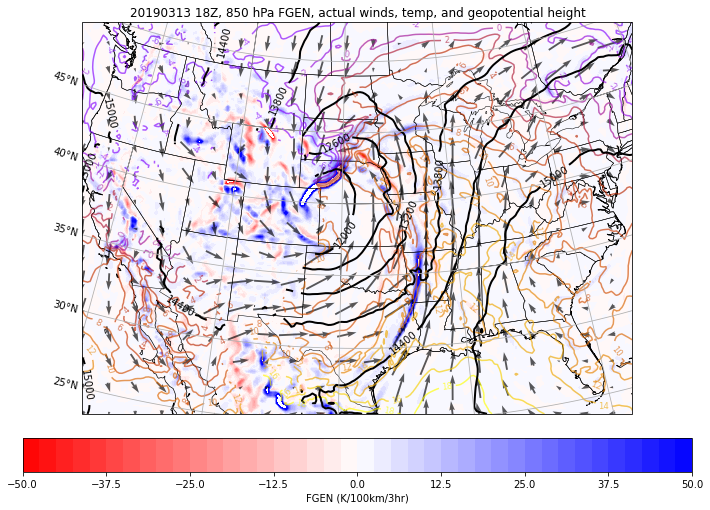

In [19]:
Map(u, v, actual_fgen, '20190313 18Z, '+str(int(lv))+' hPa FGEN, actual winds, temp, and geopotential height', 'FGEN_act'+str(int(lv))+'.jpeg')

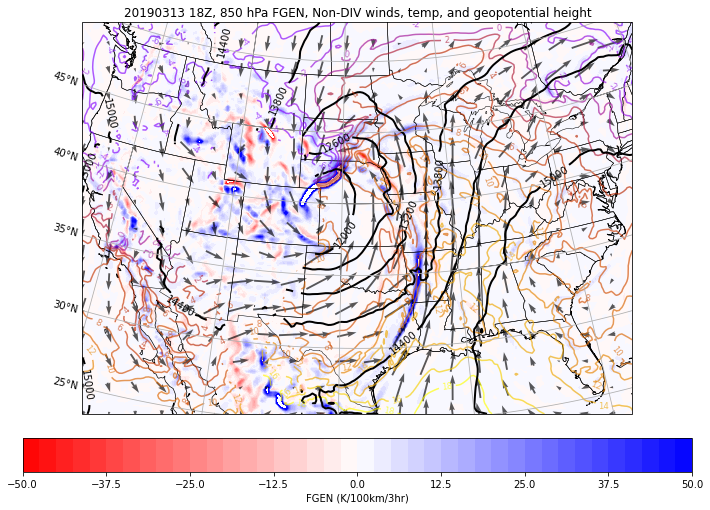

In [20]:
Map(u_n, v_n, non_fgen, '20190313 18Z, '+str(int(lv))+' hPa FGEN, Non-DIV winds, temp, and geopotential height', 'FGEN_nd'+str(int(lv))+'.jpeg')

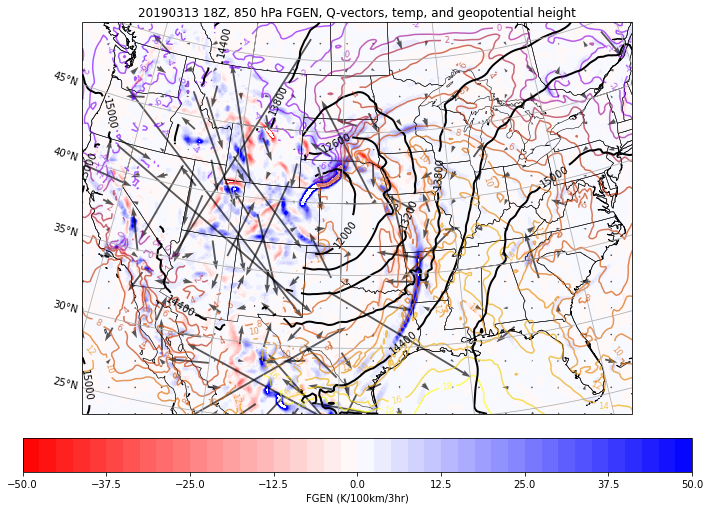

In [21]:
Map(qu, qv, non_fgen, '20190313 18Z, '+str(int(lv))+' hPa FGEN, Q-vectors, temp, and geopotential height', 'FGEN_Q'+str(int(lv))+'.jpeg')